In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
import pickle

Note: you may need to restart the kernel to use updated packages.


# PREPROCESSING

In [24]:
data = pd.read_csv("bank-full.csv",sep=";")

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


##### Dataset zawiera 45211 rekordów z czego w żadnym wierszu nie występują wartości NULL

Z opisu datasetu wynika, że jest on posortowany od maja 2008 do listopada 2010, brakuje w nim niestety kolumny rok, która połączona z pozostałymi pozwoliła by określić dokładną datę co może pomóc w analizie poniżej kod, ktory ją dodaje

In [26]:
indices = data[(data['month'] == "dec") & (data['month'].shift(-1) == "jan")].index

In [27]:
indices

Int64Index([27728, 42590], dtype='int64')

In [28]:
data['year'] = None


for index, row in data.iterrows():
    if index > 42590:  
        year = 2010
    elif index > 27728:
        year = 2009
    else:
        year = 2008       
    data.at[index, 'year'] = year

In [29]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [30]:
data.describe(include="object")

,job,marital,education,default,housing,loan,contact,month,poutcome,y,year
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2,3
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no,2008
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922,27729


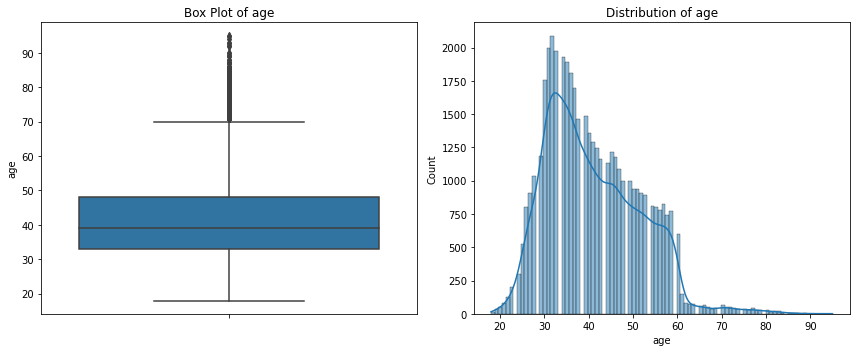

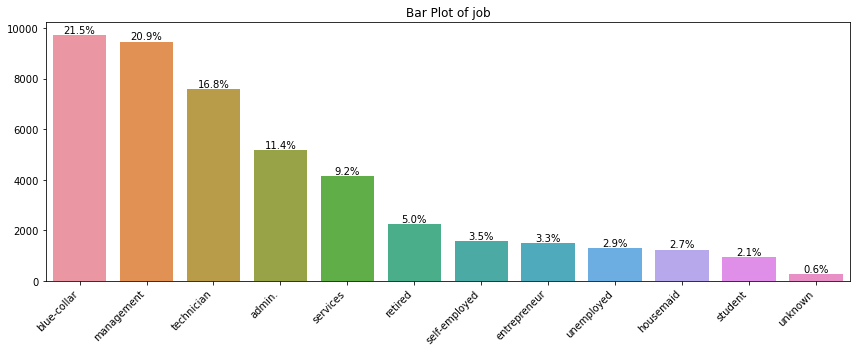

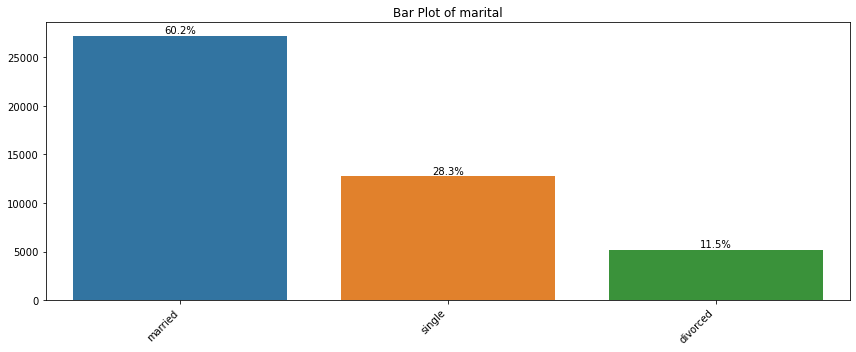

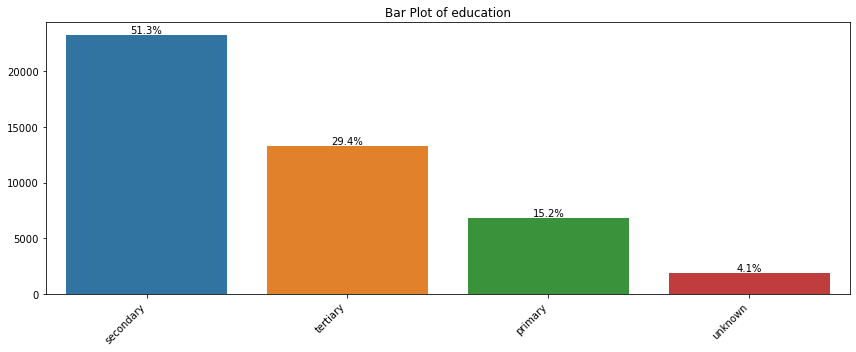

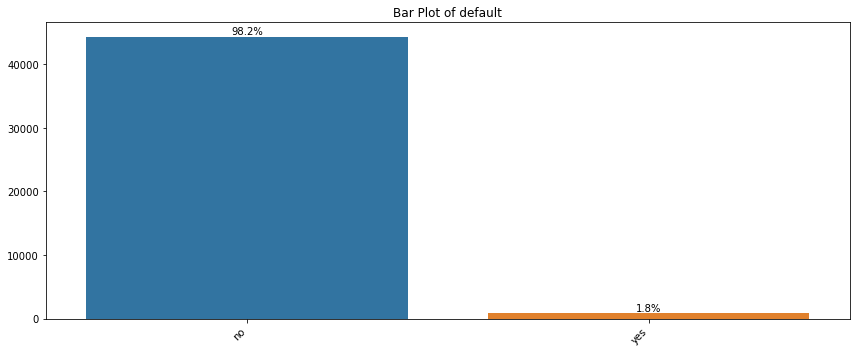

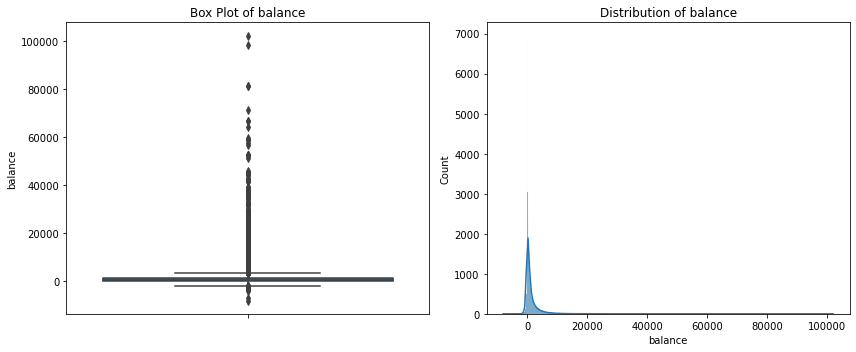

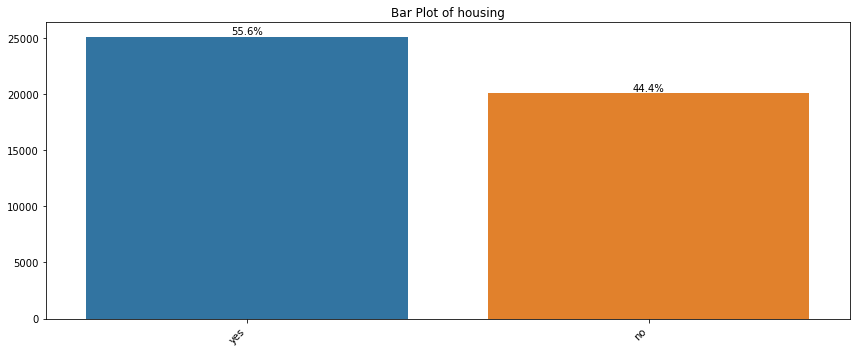

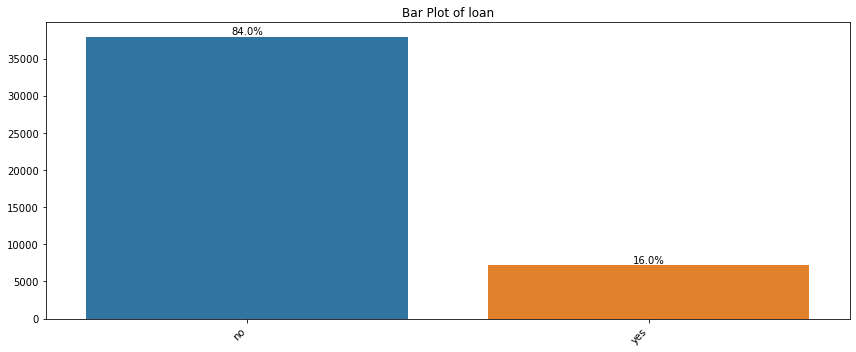

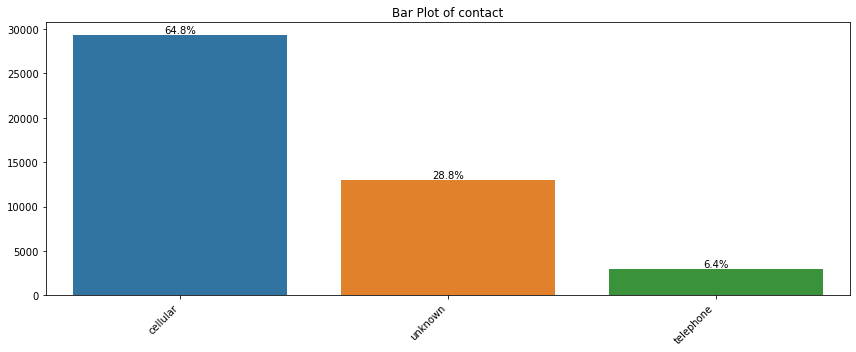

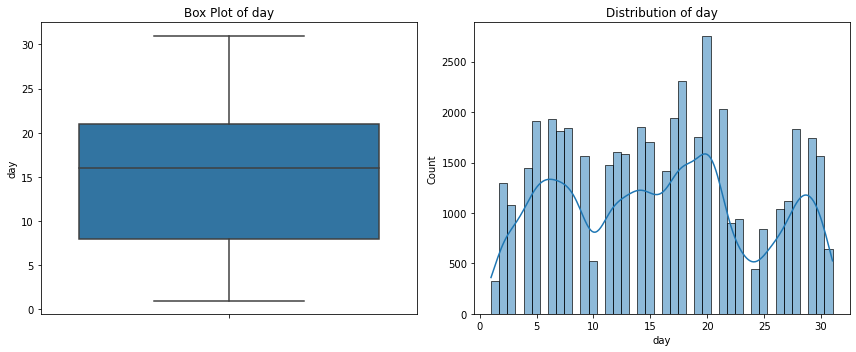

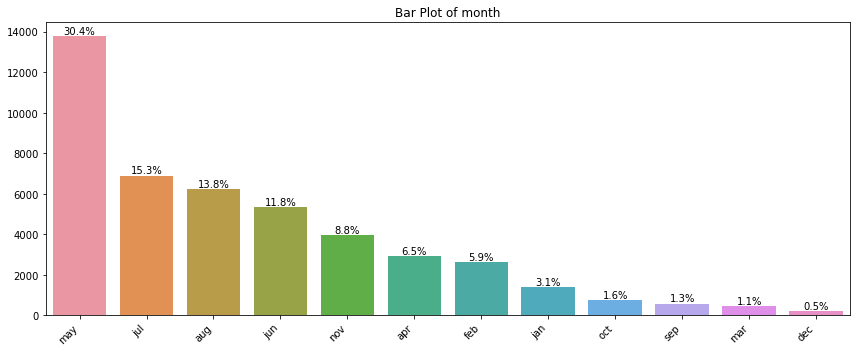

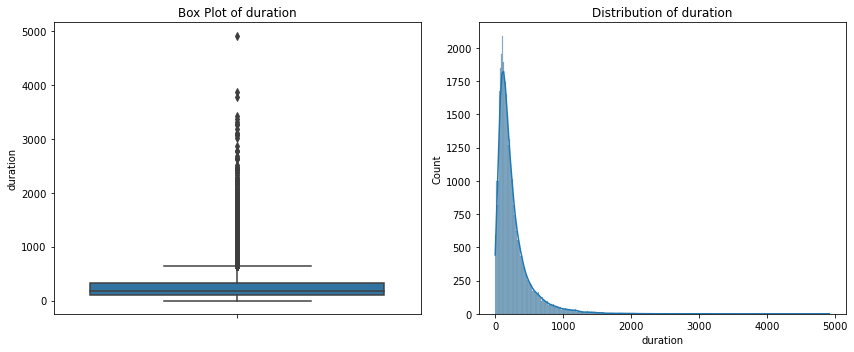

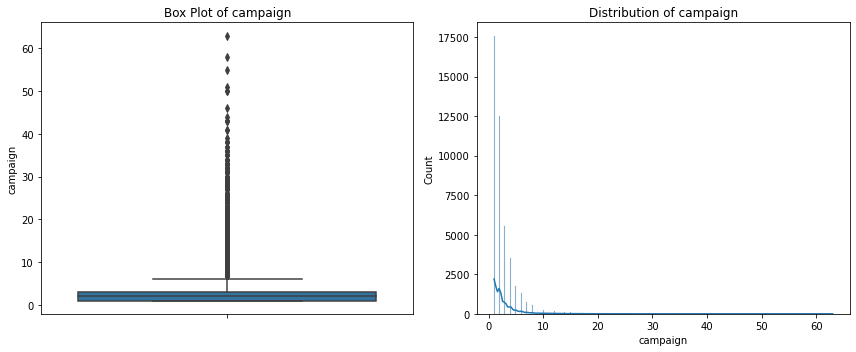

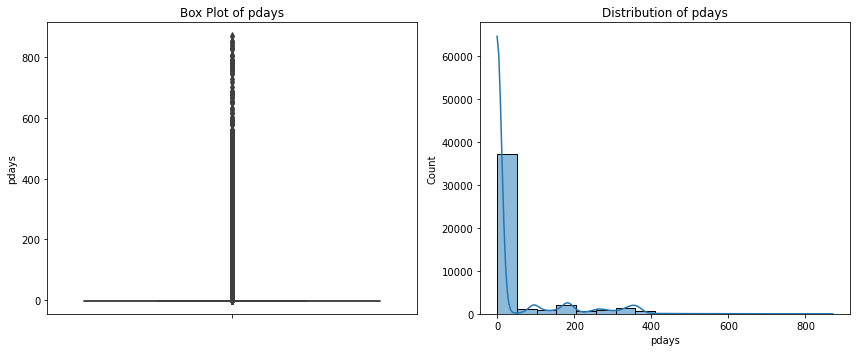

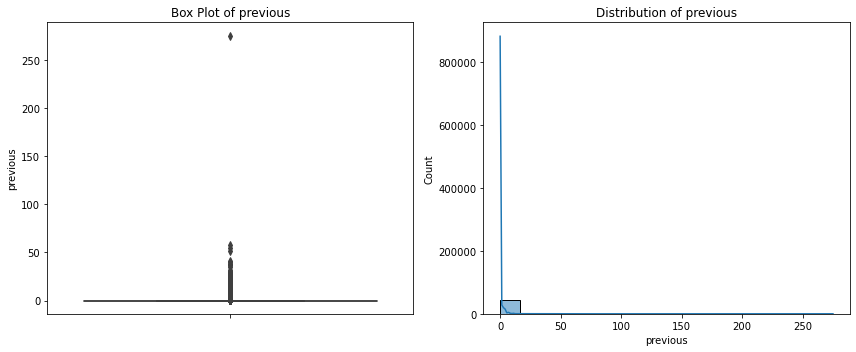

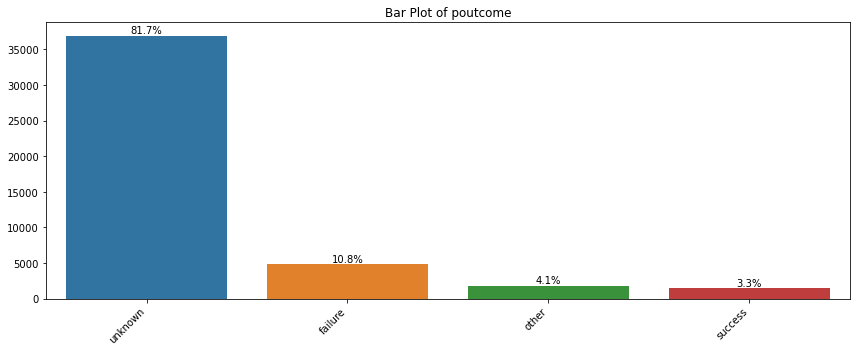

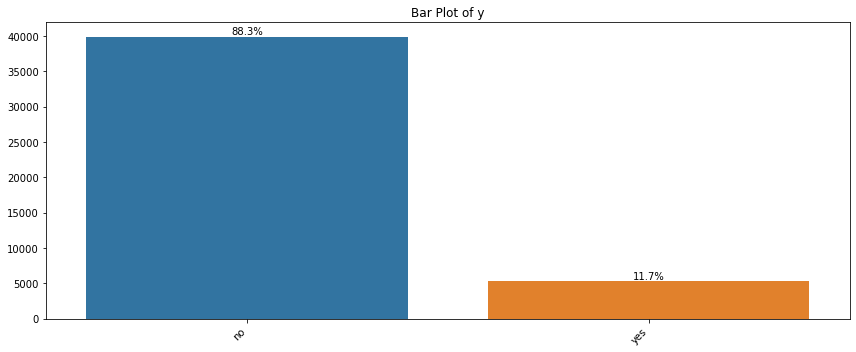

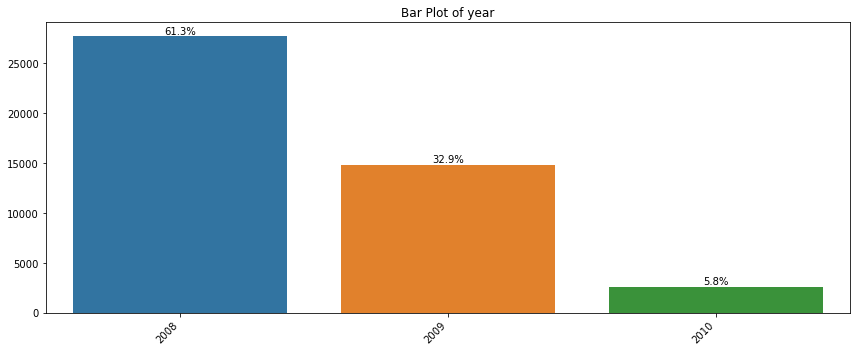

In [31]:
figsize=(12, 5)

for column in data.columns:
        
        is_numeric = pd.api.types.is_numeric_dtype(data[column])
        unique_values = data[column].nunique()
        
        
        plt.figure(figsize=figsize)
        
        
        if is_numeric and unique_values > 10:
            
            plt.subplot(1, 2, 1)
            sns.boxplot(y=data[column])
            plt.title(f'Box Plot of {column}')
            
            
            plt.subplot(1, 2, 2)
            sns.histplot(data[column], kde=True)
            plt.title(f'Distribution of {column}')
            
        else:  
            value_counts = data[column].value_counts()
            total = len(data[column])
            percentages = (value_counts / total * 100).round(1)
            
            
            ax = sns.barplot(x=value_counts.index, y=value_counts.values)
            for i, (count, percentage) in enumerate(zip(value_counts, percentages)):
                ax.text(i, count, f'{percentage}%', 
                       ha='center', va='bottom')
            plt.title(f"Bar Plot of {column}")
            plt.xticks(rotation=45, ha='right')
            
        
        plt.tight_layout()
        plt.show()

##### Analiza rozkładów cech:

#### 1. Age
Kampanie najczęściej są kierowane do klientów do 60. roku życia, gdzie tzw. górkę stanowią klienci chwilę przed i po 30. roku życia.

#### 2. Job
W kolumnie tej znajduje się 12 różnych rodzajów pracy, żaden z nich znacząco nie dominuje nad pozostałymi.

#### 3. Marital
W kolumnie tej znajdują się 3 różne statusy małżeńskie, z czego najwięcej klientów jest w związku małżeńskim.

#### 4. Education
Kolumna zawiera 4 unikalne wartości. Połowa klientów ma wykształcenie średnie, następnie 30% wyższe, a reszta podstawowe lub niewiadome.

#### 5. Default
Tylko 2% klientów ma niespłacone zobowiązania kredytowe. Klienci tacy raczej nie są skłonni do założenia lokaty.

#### 6. Balance
Wartość 75. percentyla wynosi 1428. Powyżej tej wartości występuje dużo wartości odstających, z czego maksymalna wynosi aż 102127.0.

#### 7. Housing
Trochę ponad połowa klientów ma kredyt mieszkaniowy.

#### 8. Loan
16% klientów posiada pożyczkę gotówkową.

#### 9. Contact
Z większością klientów (64.8%) kontaktowano się, dzwoniąc na numer komórkowy. Pozostali byli kontaktowani za pomocą numeru stacjonarnego bądź nieznanego.

#### 10. Day
Dzień kontaktu jest w miarę równomiernie rozłożony, z małym dołkiem od 20. do 25. dnia miesiąca.

#### 11. Month
Zaskakująco, prawie 1/3 kampanii odbywała się w maju. Następne miesiące to głównie wakacyjne.

#### 12. Duration
Długość rozmowy. Trochę poniżej 1000 sekund rozmowy zaczynają pojawiać się wartości odstające.

#### 13. Campaign
Liczba kontaktów podczas tej kampanii. Trochę poniżej 10 zaczynają się wartości odstające.

#### 14. Pdays
Liczba dni, które upłynęły od ostatniego kontaktu z klientem w ramach poprzedniej kampanii, gdzie -1 oznacza, że klient nie był poprzednio kontaktowany. Wartość ta dominuje, co oznacza, że większość klientów jest kontaktowana po raz pierwszy.

#### 15. Previous
Liczba kontaktów z klientem przed tą kampanią. column powiązana z `pdays`. Dla większości kontaktów jest to 0.

#### 16. Poutcome
Wynik poprzedniej kampanii. column związana z dwoma poprzednimi. Dla ponad 80% klientów column wynosi brak informacji, ponieważ nie brali oni udziału w poprzednich kampaniach.

#### 17. y
column celu – czy kampania odniosła sukces. Tylko 12% klientów, z którymi się skontaktowano, odpowiedziało pozytywnie na kampanię.


Kolumny job,education,contact mają ukryte wartości null czyli unkwown, wartości te zostaną zastąpione innymi wartościami w tej kolumnie bazując na prawdopodobieństwie innej wartośći

In [32]:
data_clean = data.copy()

for col in ["job", "education", "contact"]:

   
    unknown_indices = data_clean[data_clean[col] == 'unknown'].index

    
    value_counts = data_clean[data_clean[col] != 'unknown'][col].value_counts(normalize=True)

    
    random_values = np.random.choice(value_counts.index, size=len(unknown_indices), p=value_counts.values)

    
    data_clean.loc[unknown_indices, col] = random_values

W kolumnie previous znajdują się wartość other, klient był nie być w kampanii jeszcze w tego przyjmuje wartość
unknown, albo przyjąć lub odrzucić ofertę, other wymaga konsultacji biznesowej na ten moment zostanie usunięta ze zbioru danych  

In [33]:
index_other = data_clean.query("poutcome=='other'").index

data_clean.drop(index=index_other, inplace=True)

Zmienne Age,pdays,previous zostaną pominięte w procesię pozbywania się outlierów, ponieważ
naturalnie w społeczeństwie im wyższy wiek powyżej 60 roku życia tym mniej jest takich osób, nie jest to
anomalia w danych.
Z powodu tego, że większość wierszy nie była wcześniej w kampanii wartości inne niż dominujące są outlierami 
a mogą nieść przydatne informację, dlatego pozostaną w zbiorze danych.

In [34]:
print(f"Liczba wierszów przed pozbyciem się outlierów: {len(data)}")


numerical_columns = ['balance', 'day', 'campaign']
for column in numerical_columns:
    Q1 = data_clean[column].quantile(0.25)
    Q3 = data_clean[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
            
    mask = (data_clean[column] >= lower_bound) & (data_clean[column] <= upper_bound)
    data_clean = data_clean[mask]

removed_count = len(data) - len(data_clean)
removed_percentage =  round((removed_count / len(data)) * 100, 2)


print(f"Liczba pozbytych wierszy: {removed_count}, procentowo: {removed_percentage}%")        

    

Liczba wierszów przed pozbyciem się outlierów: 45211
Liczba pozbytych wierszy: 9081, procentowo: 20.09%


Zmienne pdays, previous, poutcome zależą od siebie jeśli klient nie był wcześniej kontaktowany to liczba dni 
które mineły od ostatniego kontaktu powinna wynosić 0 a wynik poprzednej kampanii unkwonw.Sprawdźmy czy tak jest

In [35]:
print(len(data_clean.query('pdays==-1 and previous!=0')))
print(len(data_clean.query('pdays!=-1 and previous==0')))
print(len(data_clean.query("pdays==-1 and previous==0 and poutcome!='unknown'")))


0
0
0


Rozkłady cech po zmianach

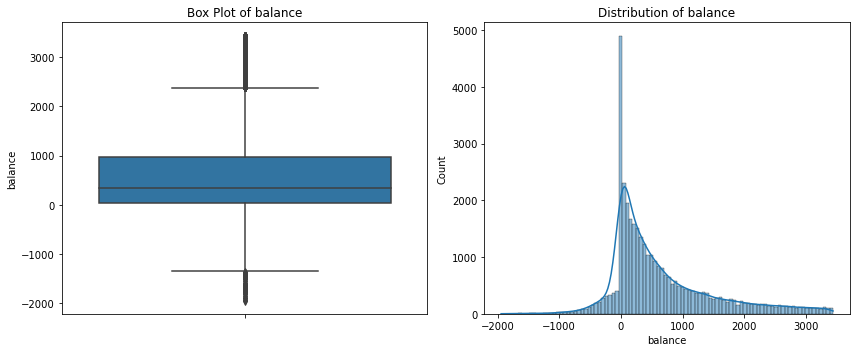

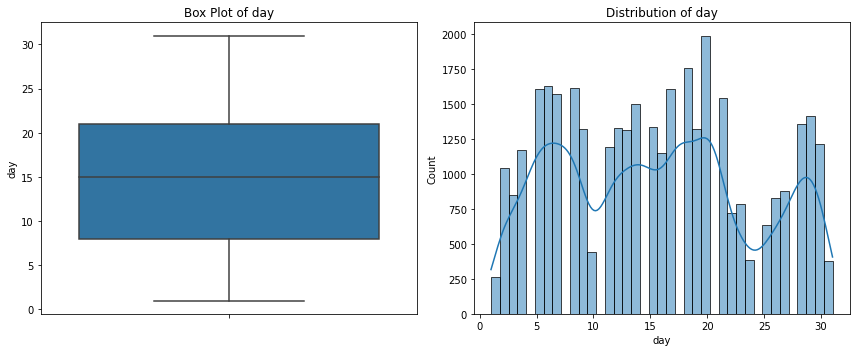

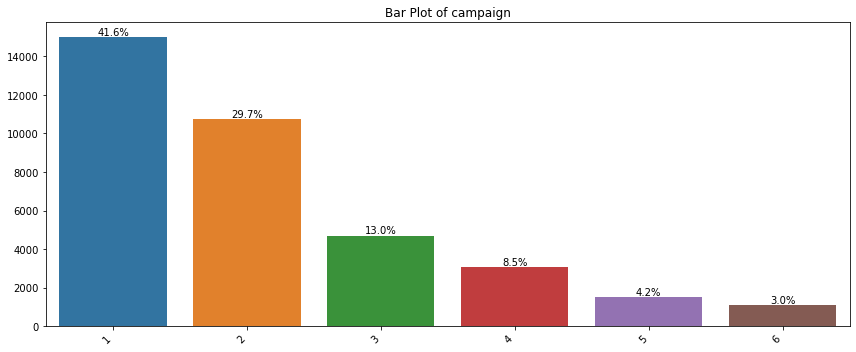

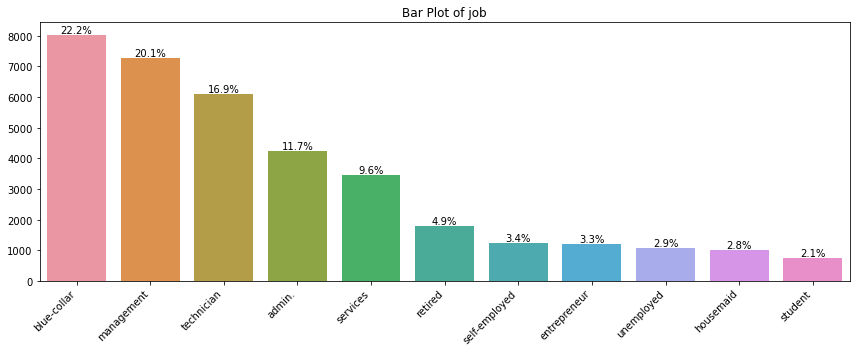

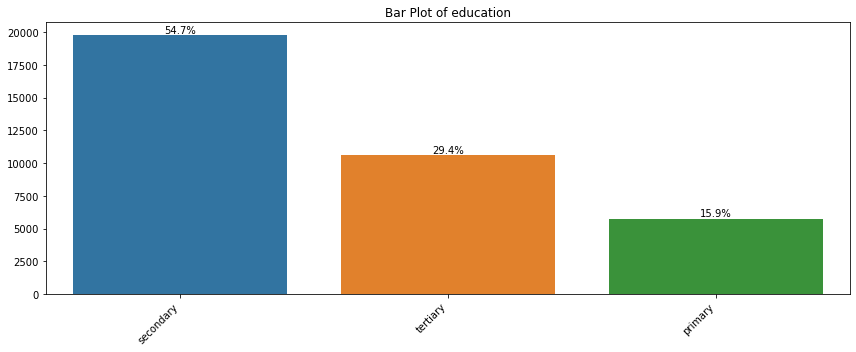

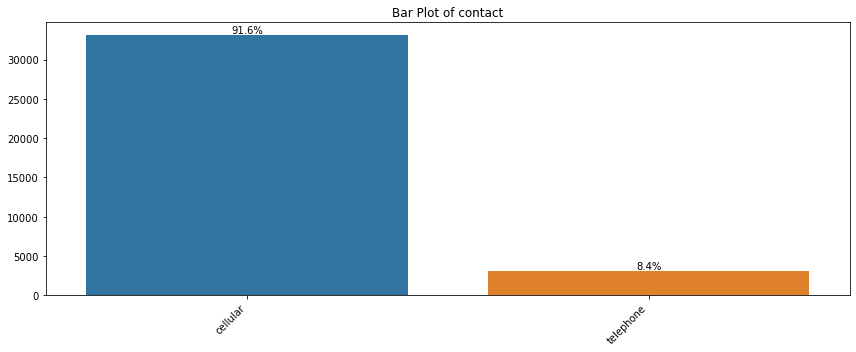

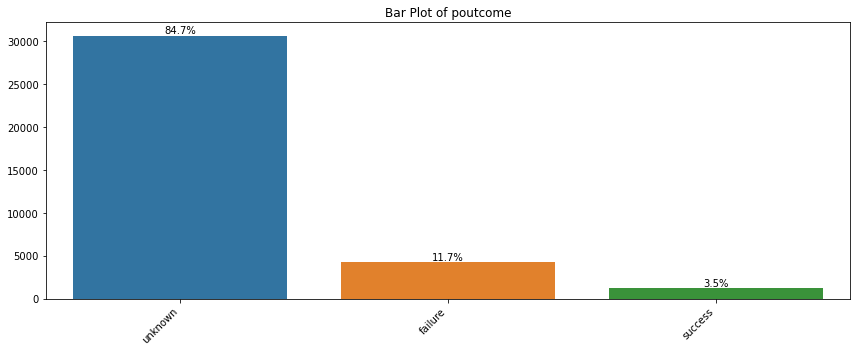

In [36]:
figsize=(12, 5)

changed_columns = numerical_columns + ["job", "education", "contact"] + ["poutcome"]

for column in changed_columns:
       
        
        
        is_numeric = pd.api.types.is_numeric_dtype(data_clean[column])
        unique_values = data_clean[column].nunique()
        
        
        plt.figure(figsize=figsize)
        
        
        if is_numeric and unique_values > 10:
            
            plt.subplot(1, 2, 1)
            sns.boxplot(y=data_clean[column])
            plt.title(f'Box Plot of {column}')
            
            
            plt.subplot(1, 2, 2)
            sns.histplot(data_clean[column], kde=True)
            plt.title(f'Distribution of {column}')
            
        else:  
            value_counts = data_clean[column].value_counts()
            total = len(data_clean[column])
            percentages = (value_counts / total * 100).round(1)
            
           
            ax = sns.barplot(x=value_counts.index, y=value_counts.values)
            for i, (count, percentage) in enumerate(zip(value_counts, percentages)):
                ax.text(i, count, f'{percentage}%', 
                       ha='center', va='bottom')
            plt.title(f"Bar Plot of {column}")
            plt.xticks(rotation=45, ha='right')
            
       
        plt.tight_layout()
        plt.show()

Wykresy przedstawiające, zależność cechy od y

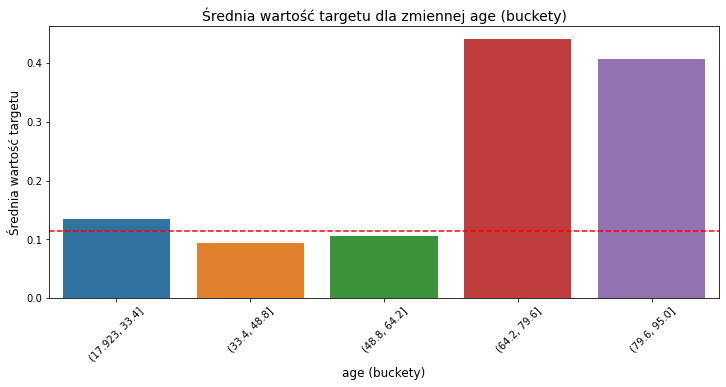

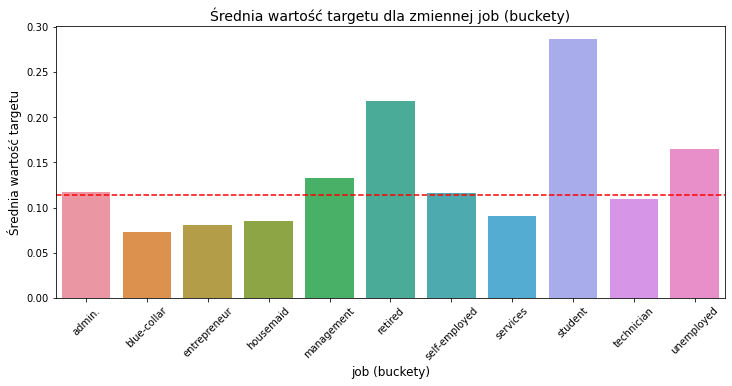

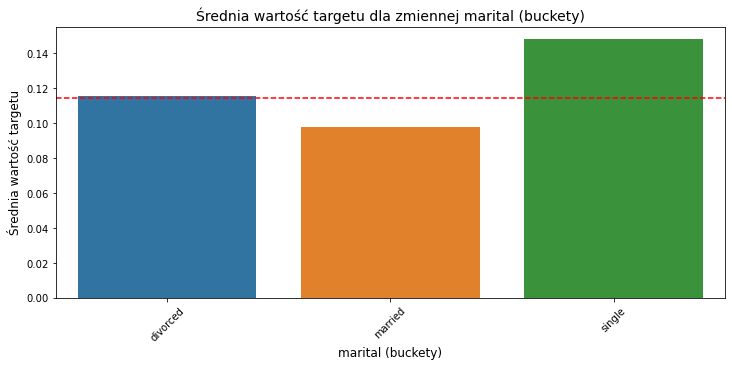

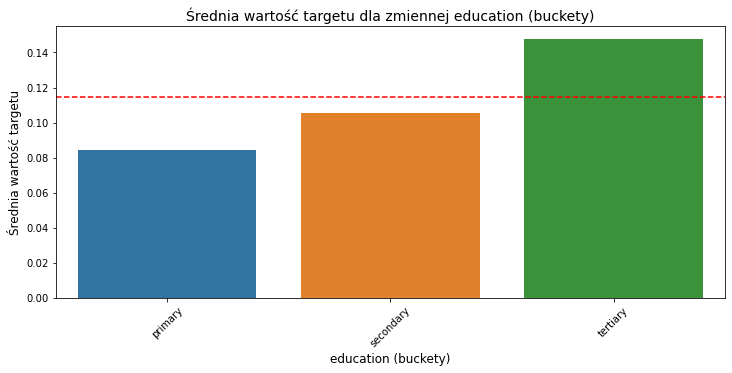

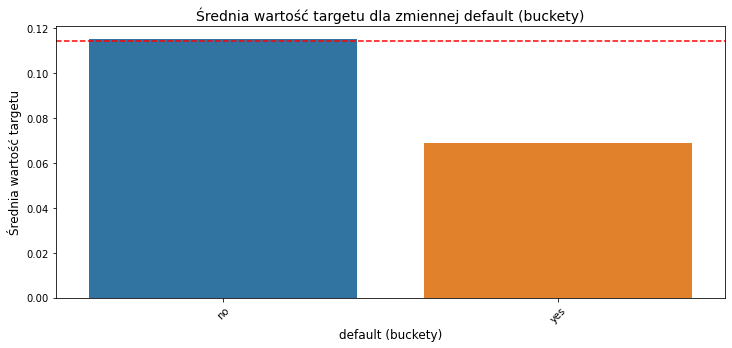

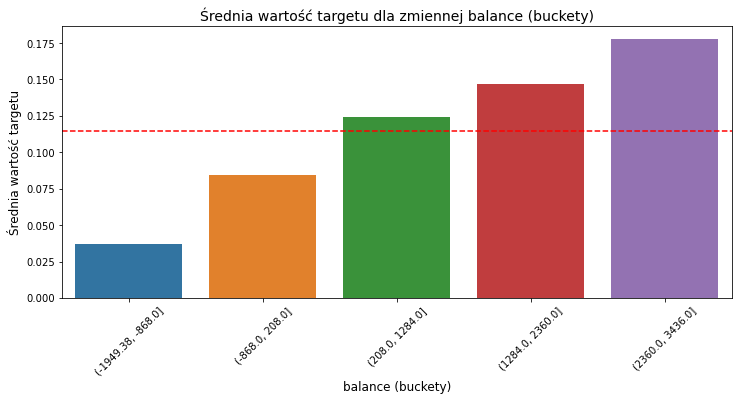

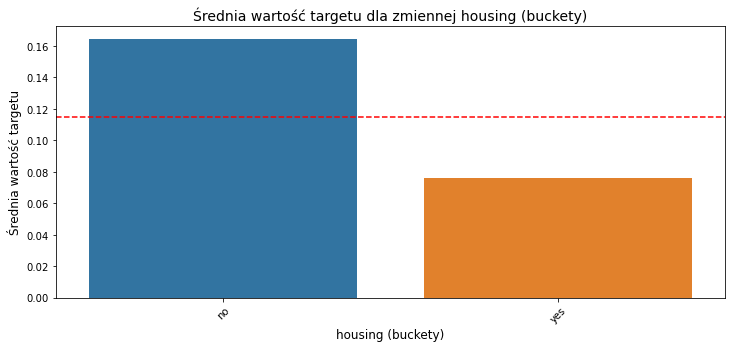

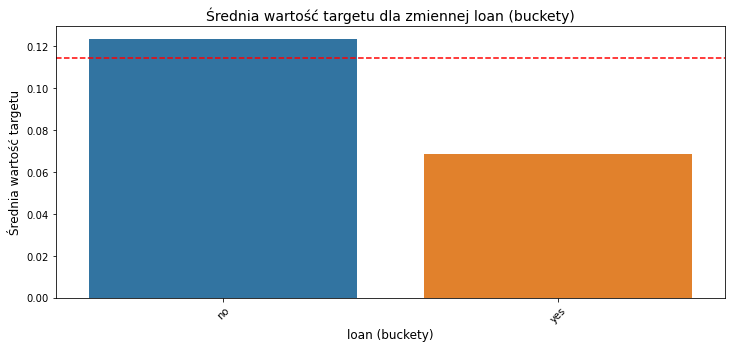

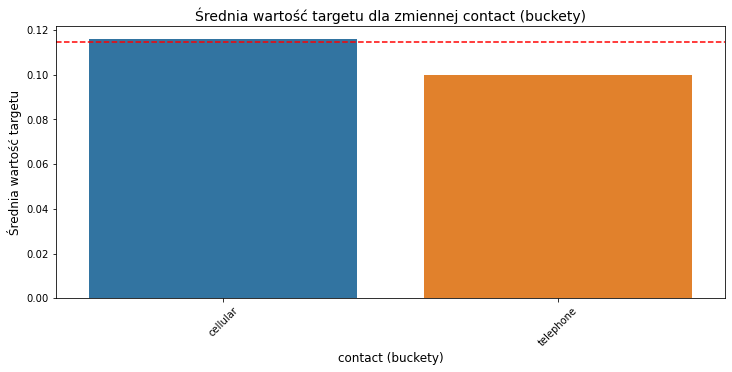

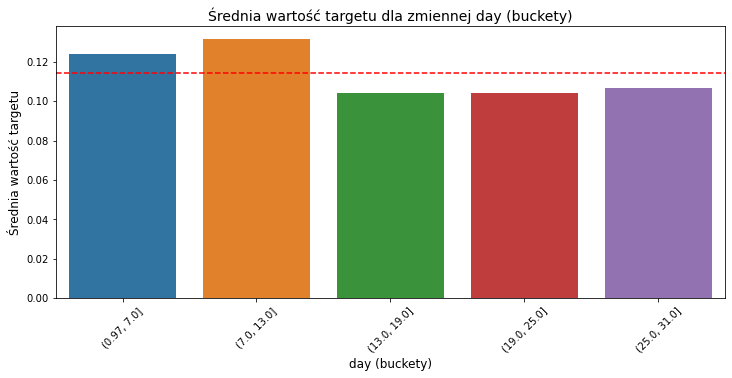

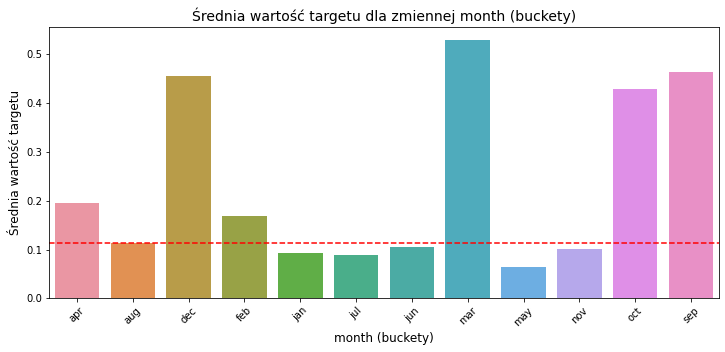

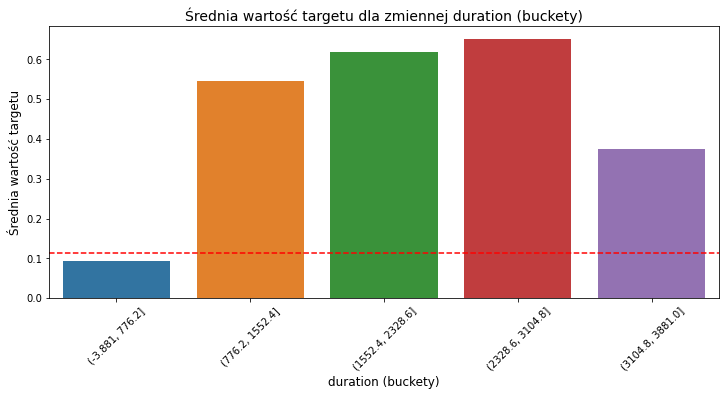

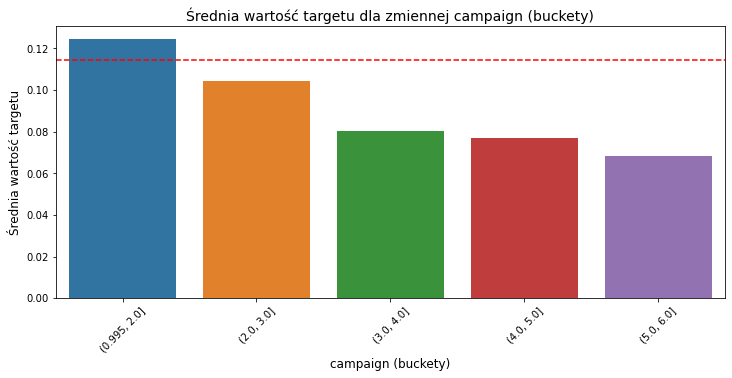

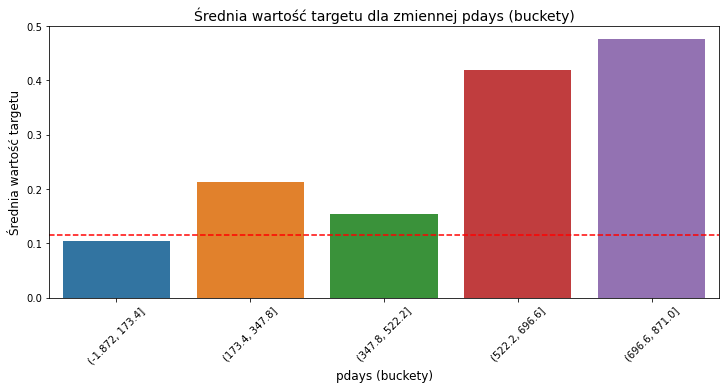

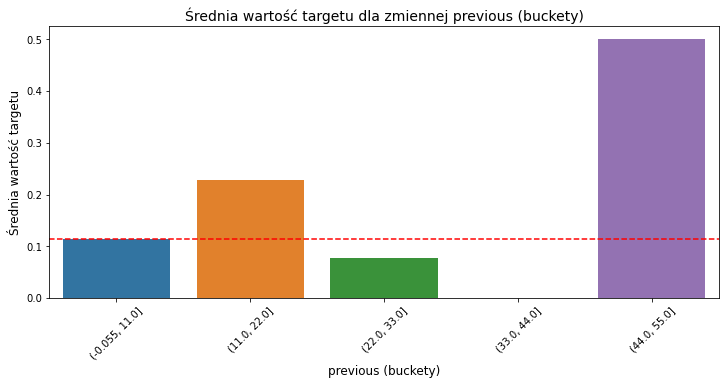

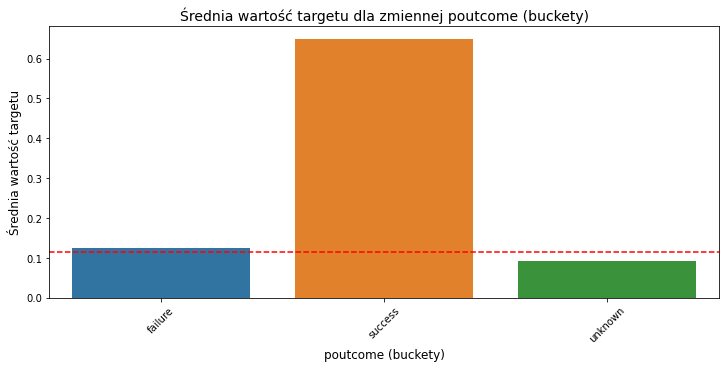

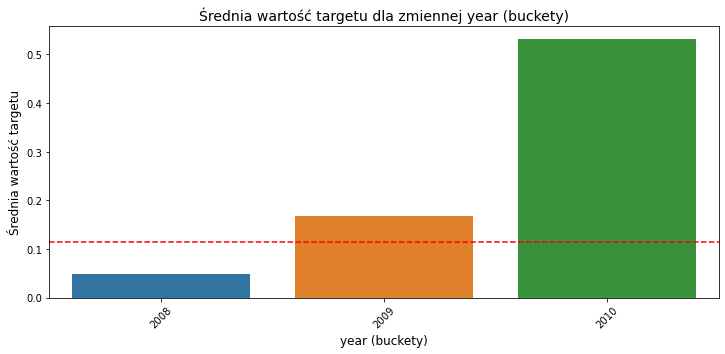

In [37]:
figsize=(12, 5)

data_clean["y"] = data_clean["y"].map({"no":0, "yes": 1})

global_mean_target = data_clean['y'].mean()

tmp_frame = data_clean.copy()

cols = list(data_clean.columns)

cols.remove("y")

for column in cols:
        
        is_numeric = pd.api.types.is_numeric_dtype(tmp_frame[column])
        
        
        
        plt.figure(figsize=figsize)
        
        
        if is_numeric:
            tmp_frame[f'{column}_bucket'] = pd.cut(tmp_frame[column], bins=5)
    
            
            srednia_target = tmp_frame.groupby(f'{column}_bucket')['y'].mean().reset_index()
            
            
            sns.barplot(x=f'{column}_bucket', y='y', data=srednia_target)
            plt.title(f'Średnia wartość targetu dla zmiennej {column} (buckety)', fontsize=14)
            plt.xlabel(f'{column} (buckety)', fontsize=12)
            plt.ylabel('Średnia wartość targetu', fontsize=12)
            plt.tick_params(axis='x', rotation=45)
            plt.axhline(global_mean_target, color='red', linestyle='--', linewidth=1.5, label='Średnia targetu (globalna)')
            
        elif not is_numeric and column!="y":  
            
            srednia_target = tmp_frame.groupby(column)['y'].mean().reset_index()
            
            
            sns.barplot(x=column, y='y', data=srednia_target)
            plt.title(f'Średnia wartość targetu dla zmiennej {column} (buckety)', fontsize=14)
            plt.xlabel(f'{column} (buckety)', fontsize=12)
            plt.ylabel('Średnia wartość targetu', fontsize=12)
            plt.tick_params(axis='x', rotation=45)
            plt.axhline(global_mean_target, color='red', linestyle='--', linewidth=1.5, label='Średnia targetu (globalna)') 


1. Mimo stanowienia mniejszości starsi ludzie są bardziej podatni na kampanie,
wraz z osobami do 33 roku życia
2. Admini, emeryci oraz studenci są bardziej skłonni do założenia lokaty
3. Single oraz osoby z wyższym wykształceniem są bardziej skłonne
4. Niespłacony kredyt nie ma zbytnio wpływu na target
5. Im wyższe średnie roczne saldo tym wyższa skłonność do założenia lokaty
6. Brak kredytu mieszkaniowego jest bardziej skłonny do założenia lokaty
7. Posiadanie pożyczki nie wpływa na założenie lokaty
8. Rodzaj telefonu na jaki jest dzwonione nie wpływa znacząco na target
9. Na początku miesiąca jest większe prawdopodobieństwo skuteczności kampanii
10. Miesiące Kwiecień, Grudzień, Marzec, Październik i Wrzesień mają wyższą skuteczność kampanii
11. Im dłuższa rozmowa tym wyższe prawdopodobieństwo pozytywnej kampanii
12. Im częściej się kontaktyujemy podczas danej kampanii z klientem tym bardziej spada 
prawdopodobieństwo skuteczności kampanii
13. Klienci, którzy byli wcześniej w kampanii mają większe prawdopodobieństwo na założenie kolejnej lokaty

# Hipotezy

1. Klienci z wyższym średnim rocznym saldem częściej decydują się na lokatę długoterminową

In [38]:

group_target = data_clean[data_clean['y'] == 1]['balance']
group_no_target = data_clean[data_clean['y'] == 0]['balance']


_, p_value_target = stats.normaltest(group_target)
_, p_value_no_target = stats.normaltest(group_no_target)


if p_value_target > 0.05 and p_value_no_target > 0.05:
    
    t_statistic, p_value = stats.ttest_ind(group_target, group_no_target)
    test_name = "T-test"
else:
    
    t_statistic, p_value = stats.mannwhitneyu(group_target, group_no_target)
    test_name = "Mann-Whitney U test"

print(f"{test_name} p-value: {p_value}")
print(f"Średnie saldo: \nLokata długoterminowa: {group_target.mean()}\nBez lokaty: {group_no_target.mean()}")

Mann-Whitney U test p-value: 1.8636699457467634e-74
Średnie saldo: 
Lokata długoterminowa: 851.2337850919652
Bez lokaty: 611.769548096756


p < 0,05, można wnioskować, że klienci z lokаtą mają istotnie różne średnie saldo niż ci bez lokaty.

2. W Maju klienci rzadziej decydują się na lokatę w porównaniu z innymi miesiącami 

In [39]:
from scipy.stats import chi2_contingency


contingency_table = pd.crosstab(data_clean['month'] == 5, data_clean['y'])


chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"P-value: {p_value}")

P-value: 1.0


Istnieje wysoce istotna statystyczna różnica w decyzjach o lokacie między majem a pozostałymi miesiącami.

# Feature-Enginnering

In [19]:

data_clean['month'] = pd.to_datetime(data_clean['month'], format='%b').dt.month

data_clean['date'] = pd.to_datetime(data_clean[['year', 'month', 'day']])


data_clean['weekday'] = data_clean['date'].dt.weekday


data_clean['is_weekend'] = data_clean['weekday'] >= 5



Z powodu tego że zmienna campaign zawiera ostatni kontakt a w trakcie modelowania jesteśmy jeszcze przed nim, powinniśmy usunąć zmienną duration a od campgain odjąć -1

In [20]:
data_clean["campaign"] = data_clean["campaign"] - 1


In [21]:
data_clean.drop(columns=["duration",  "year", "date"], inplace=True)

In [28]:
data_clean = data_clean.drop_duplicates()

In [22]:
X = data_clean.drop(columns=["y"])
y = data_clean["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,shuffle=True)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30172, 17), (7544, 17), (30172,), (7544,))

In [24]:
columns_to_encode = X_train.select_dtypes("object").columns

In [25]:
X_train[columns_to_encode].describe()

,job,marital,education,default,housing,loan,contact,poutcome
count,30172,30172,30172,30172,30172,30172,30172,30172
unique,11,3,3,2,2,2,2,4
top,blue-collar,married,secondary,no,yes,no,cellular,unknown
freq,6744,17919,16528,29598,17135,25131,27580,24472


In [26]:
columns_to_encode = X_train.select_dtypes("object").columns

encoder = TargetEncoder(random_state=42)
X_train_encoded = encoder.fit_transform(X_train[columns_to_encode], y_train)
X_test_encoded = encoder.transform(X_test[columns_to_encode])


X_train[columns_to_encode] = X_train_encoded
X_test[columns_to_encode] = X_test_encoded

In [27]:
cols_to_standard = [col for col in X_train.columns if col not in columns_to_encode]

standardscaler = StandardScaler()

X_train_scaled = standardscaler.fit_transform(X_train[cols_to_standard], y_train)
X_test_scaled = standardscaler.transform(X_test[cols_to_standard])


X_train[cols_to_standard] = X_train_scaled
X_test[cols_to_standard] = X_test_scaled

1. Podejście z naturalnym zagęszczeniem

In [38]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42)
}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{name} - Średnia roc_auc: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Random Forest - Średnia roc_auc: 0.7615 ± 0.0113
Decision Tree - Średnia roc_auc: 0.5954 ± 0.0060
KNN - Średnia roc_auc: 0.6594 ± 0.0075
XGBoost - Średnia roc_auc: 0.7592 ± 0.0119


2. Z wykorzystaniem oversamplingu

In [39]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

smote = SMOTE(random_state=42)

scores = []

for name, model in models.items():

   
    for train_idx, test_idx in cv.split(X_train, y_train):
        
        X_train_cv, X_test_cv = X_train.iloc[train_idx,:], X_train.iloc[test_idx,:]
        y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        
        X_train_res, y_train_res = smote.fit_resample(X_train_cv, y_train_cv)
        
        
        model.fit(X_train_res, y_train_res)
        
        
        y_pred_cv = model.predict_proba(X_test_cv)
        score = roc_auc_score(y_test_cv, y_pred_cv[:,1])
        scores.append(score)

    
    mean_score = np.mean(scores)
    std_score = np.std(scores)

    print(f"{name} - Średnia roc_auc: {mean_score:.4f} ± {std_score:.4f}")

Random Forest - Średnia roc_auc: 0.5848 ± 0.0520
Decision Tree - Średnia roc_auc: 0.5443 ± 0.0560
KNN - Średnia roc_auc: 0.5853 ± 0.0741
XGBoost - Średnia roc_auc: 0.6003 ± 0.0711


3. Z wykorzystaniem downsamplingu

In [40]:


under_sampler = RandomUnderSampler(random_state=42)

scores = []

for name, model in models.items():

   
    for train_idx, test_idx in cv.split(X_train, y_train):
        
        X_train_cv, X_test_cv = X_train.iloc[train_idx,:], X_train.iloc[test_idx,:]
        y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        
        X_train_res, y_train_res = under_sampler.fit_resample(X_train_cv, y_train_cv)
        
        
        model.fit(X_train_res, y_train_res)
        
        
        y_pred_cv = model.predict_proba(X_test_cv)
        score = roc_auc_score(y_test_cv, y_pred_cv[:,1])
        scores.append(score)

    
    mean_score = np.mean(scores)
    std_score = np.std(scores)

    print(f"{name} - Średnia roc_auc: {mean_score:.4f} ± {std_score:.4f}")

Random Forest - Średnia roc_auc: 0.7637 ± 0.0123
Decision Tree - Średnia roc_auc: 0.6895 ± 0.0758
KNN - Średnia roc_auc: 0.6876 ± 0.0622
XGBoost - Średnia roc_auc: 0.7016 ± 0.0598


Najlepiej wypada opcja 1 czyli bez downsamplingu oraz oversamplingu danych. Pozostał jeszcze wybór modelu Random Forest oraz XGBoost wypadają podobnie, więc w następnym kroku zostanie przeprowadzona optymalizacja hiperparametrów w celu wyboru najlepszego modelu

In [41]:
param_spaces = {
    'Random Forest': {
        'n_estimators': (50, 300),  
        'max_depth': (3, 20),  
        'min_samples_leaf': (1, 100),
    },
    'XGBoost': {
        'n_estimators': (50, 300),  
        'learning_rate': (0.01, 0.3, 'uniform'),  
        'max_depth': (3, 20),  
        'subsample': (0.5, 1.0),  
        'colsample_bytree': (0.5, 1.0),
        'min_child_weight': (1, 100),
    }
}


models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}


best_models = {}
for model_name, model in models.items():
    print(f"Optymalizacja hiperparametrów dla {model_name}...")
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_spaces[model_name],
        n_iter=50,  
        cv=5,  
        n_jobs=-1,  
        random_state=42,
        verbose=4
    )
    bayes_search.fit(X_train, y_train)
    best_models[model_name] = bayes_search.best_estimator_
    print(f"Najlepsze parametry dla {model_name}: {bayes_search.best_params_}")

Optymalizacja hiperparametrów dla Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitti

In [42]:
for name, model in best_models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{name} - Średnia roc_auc: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Random Forest - Średnia roc_auc: 0.7700 ± 0.0123
XGBoost - Średnia roc_auc: 0.7825 ± 0.0122


In [43]:
prod_model = best_models["XGBoost"]

In [45]:
prod_model.fit(X_train, y_train)

y_train_proba = prod_model.predict_proba(X_train)
y_pred_proba = prod_model.predict_proba(X_test)

auc_train = round(roc_auc_score(y_train, y_train_proba[:,1]), 4)
auc_test = round(roc_auc_score(y_test, y_pred_proba[:,1]), 4)

print(f"ROC_AUC_SCORE na treningowym: {auc_train}")
print(f"ROC_AUC_SCORE na testowym: {auc_test}")


ROC_AUC_SCORE na treningowym: 0.8608
ROC_AUC_SCORE na testowym: 0.7958


In [80]:
with open('prod_model.pkl', 'wb') as file:
   pickle.dump(prod_model, file)

In [29]:
data_clean.to_csv("data_clean.csv",index=False)